## 손실함수

'하나의 지표'를 기준으로 최적의 매개변수 값을 탐색할 때 사용하는 지표

일반적으로 오차제곱합과 교차 엔트로피 오차를 사용함.

## 오차제곱합

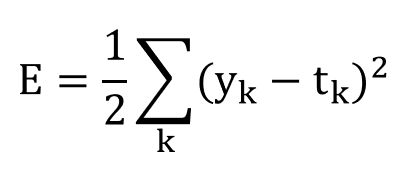

In [1]:
import numpy as np
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]    # 2가 가장 높다고 추정
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]  # 정답은 2

def sum_squares_error(y, t):
  return 0.5 * np.sum((y-t)**2)

print(sum_squares_error(np.array(y), np.array(t)))          # 오차가 작음

y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]    # 7일 확률이 가장 높다고 추정
print(sum_squares_error(np.array(y), np.array(t)))          # 오차가 큼

0.09750000000000003
0.5975


### 교차 엔트로피 오차

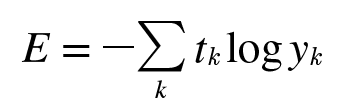

- log는 밑이 e인 자연로그임.
- yk는 신경망의 출력, tk는 정답 레이블임.
- tk는 정답에 해당하는 인덱스의 원소만 1이고 나머지는 0임.
- 정답일 때의 추정(tk가 1일 때의 yk)의 자연로그를 계산하는 식이됨.

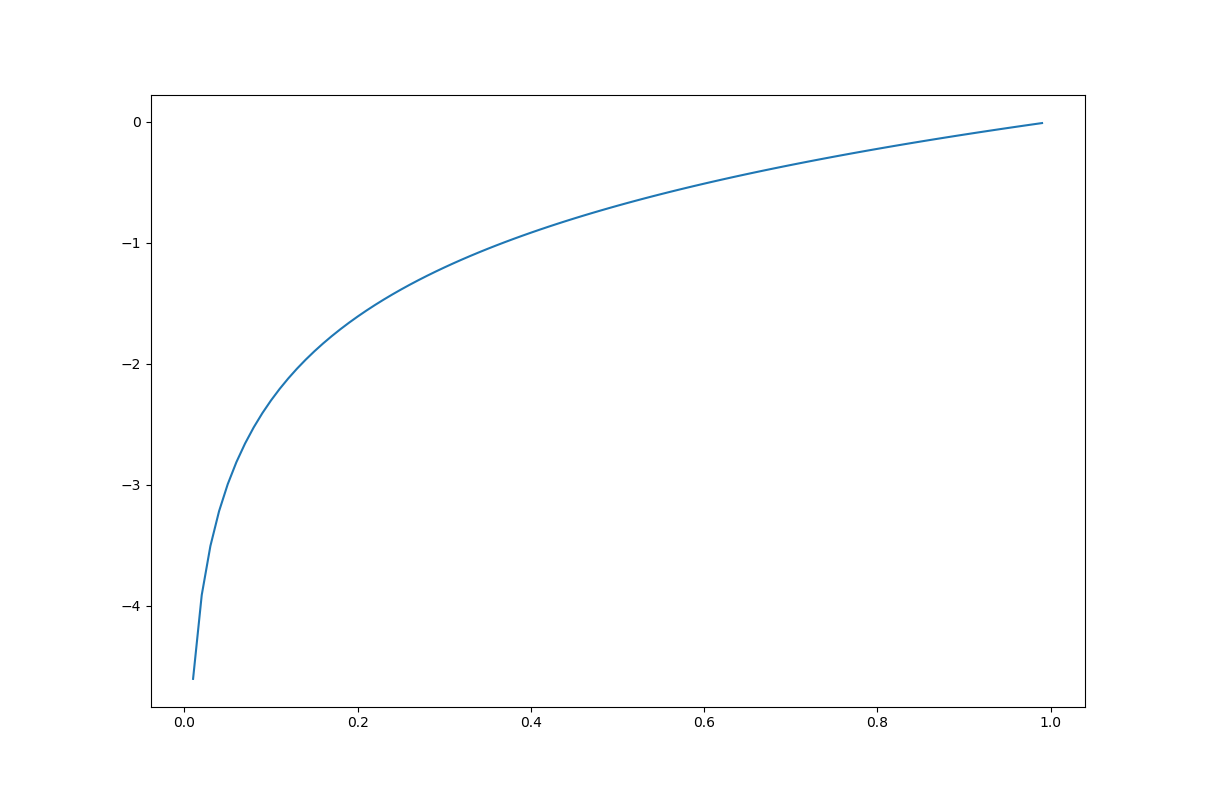

- x가 1일 때는 y는 0이 되고 x가 0에 가까워질수록 y의 값은 점점 작아짐.
- 정답에 해당하는 출력이 커질 수록 0에 다가가다가, 그 출력이 1일 때 0이됨.

In [2]:
def cross_entropy_error(y, t):
  delta = 1e-7
  return -np.sum(t * np.log(y + delta))

In [3]:
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

print(cross_entropy_error(np.array(y), np.array(t)))      # 오차가 작음

y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0] 
print(cross_entropy_error(np.array(y), np.array(t)))      # 오차가 큼.

0.510825457099338
2.302584092994546


### 미니배치 학습

데이터가 많을 시, 모든 데이터를 대상으로 손실 함수의 합을 구하기에는 시간이 걸리기 때문에 현실적으로 어려움.

이런 경우 데이터 일부를 추려 전체의 '근사치'로 이용함.

이 일부를 미니배치라고 하며, 미니배치를 통해 학습하는 것을 미니배치학습이라고함.

In [4]:
%cd /content/drive/MyDrive/colab/deep_learning_basic/밑바닥부터_시작하는_딥러닝

/content/drive/MyDrive/colab/deep_learning_basic/밑바닥부터_시작하는_딥러닝


In [5]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [6]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)   # 무작위로 원하는 개수만 꺼냄
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

### (배치용) 교차 엔트로피 오차 구하기

In [7]:
# 데이터 하나당 교차 엔트로피 오차 구하는 경우
def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  batch_size = y.shape[0]
  return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [8]:
# 정답 레이블이 원-핫 인코딩이 아니라 '2'나 '7' 등의 숫자 레이블로 주어졌을 때의 교차 엔트로피
def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t]) + 1e-7) / batch_size

### *왜 손실 함수를 설정하는가?

신경망 학습에서는 최적의 매개변수(가중치와 편향)를 탐색할 때 손실함수의 값을 간으한 한 작게 하는 매개변수 값을 찾습니다. 이때 매개변수의 미분(기울기)을 계산하고, 그 미분 값을 단서로 매개변수의 값을 서서히 갱신하는 과정을 반복합니다.


가중치 매개변수의 손실 함수의 미분이란 ' 가중치 매개변수의 값을 아주 조금 변화 시켰을 때, 손실 함수가 어떻게 변하나'라는 의미입니다. 만약 이 미분 값이 음수면 그 가중치 매개변수를 양의 방향으로 변화시켜 손실 함수의 값을 줄일 수 있습니다. 반대로, 미분 값이 양수면 가중치 매개변수를 음의 방향으로 변화시켜 손실 함수의 값을 줄일 수 있습니다. 그러나 미분 값이 0이면 가중치 매개변수를 어느 쪽으로도 움직여도 손실 함수의 값은 줄어들지 않습니다. 그래서 가중치 매개변수의 갱신은 거기서 멈춥니다.


정확도를 지표로 삼아서는 안 되는 이유는 미분 값이 대부분의 장소에서 0이 되어 매개변수를 갱신할 수 없기 때문입니다.




#### *정확도를 지표로 삼으면 매개변수의 미분이 대부분의 장소에서 0이 되는 이유

정확도는 매개변수의 미세한 변화에는 거의 반응을 보이지 않고, 반응이 있더라도 그 값이 불연속적으로 갑자기 변화합니다. 이는 '계단 함수'를 활성화 함수로 사용하지 않는 이유와 동일합니다.

## 수치 미분

### 미분

미분은 '특정 순간'의 변화량을 뜻함.

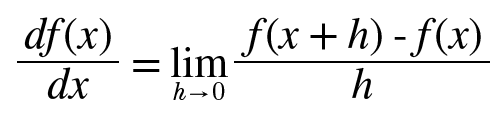

In [9]:
# 나쁜 구현 예
# 반올림 오차 문제를 일으킴. h를 무한히 0으로 좁히는 것이 불가능
def numerical_diff(f, x):
  h = 10e-50
  return (f(x + h) - f(x)) / h

[진정한 미분(진정한 접선)과 수치 미분(근사로 구한 접선)의 값은 다르다.

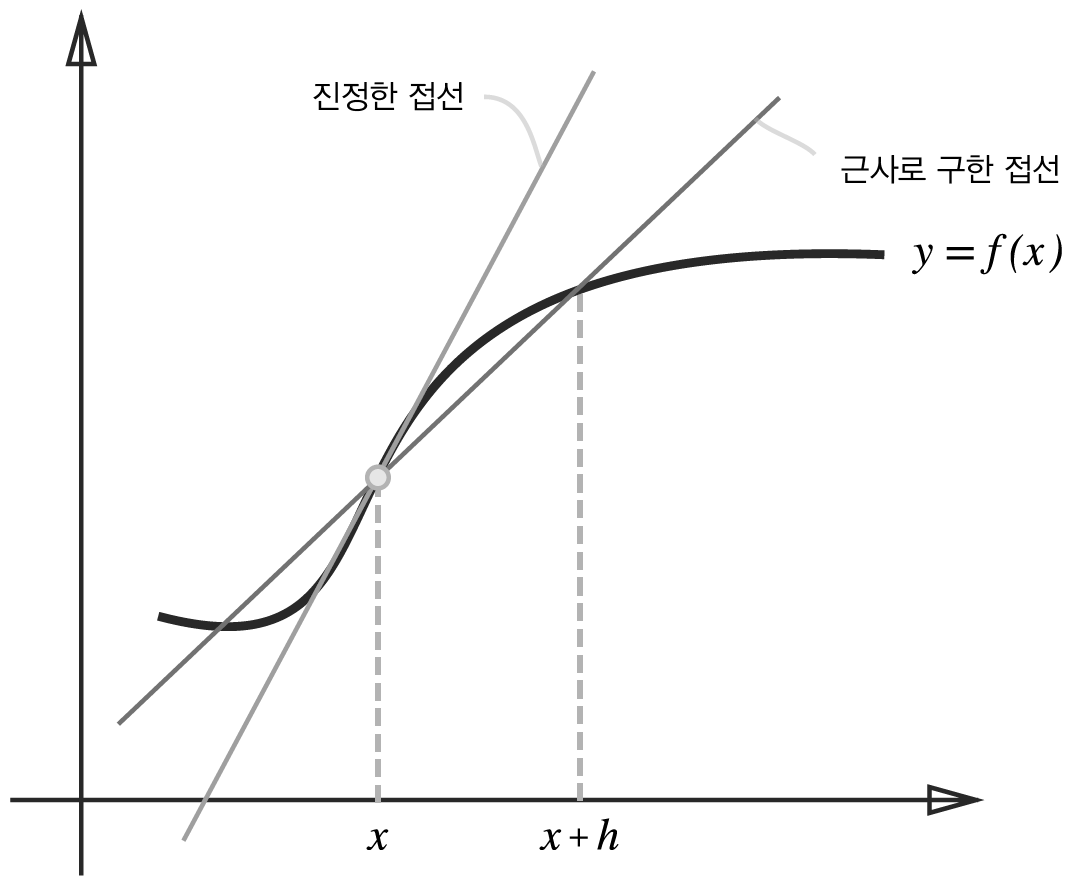

- 수치 미분에는 오차가 포함됨.
- 이 오차를 줄이기 위해(x + h)와 (x - h)일 때의 함수 f의 차분을 계산하는 방법을 쓰기도함.
- 이 차분은 x를 중심으로 그 전후의 차분을 계산한다는 의미에서 중심 차분 혹은 중앙 차분이라 함.
- 아주 작은 차분으로 미분하는 것을 수치 미분이라 함.

In [10]:
# 개선점 적용한 식
def numerical_diff(f, x):
  h = 1e-4
  return (f(x+h) - f(x-h)) / (2*h)

### 수치 미분의 예

In [11]:
def function_1(x):
  return 0.01*x**2 + 0.1*x

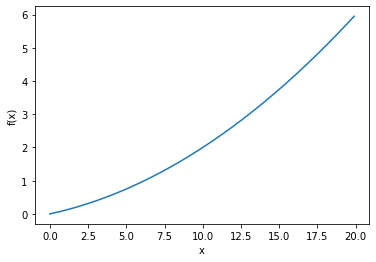

In [12]:
import numpy as np
import matplotlib.pylab as plt

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.plot(x, y)
plt.show()

In [13]:
# x = 5일 때와 10일 때 이 함수의 미분 계산

print(numerical_diff(function_1, 5))
print(numerical_diff(function_1, 10))

0.1999999999990898
0.2999999999986347


0.1999999999990898


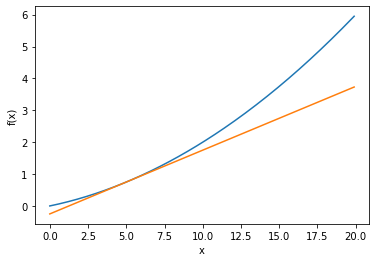

0.2999999999986347


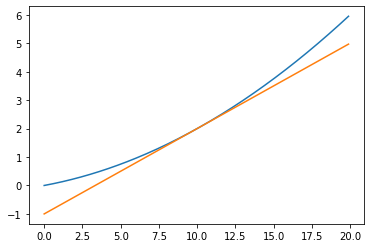

In [14]:
import numpy as np
import matplotlib.pylab as plt

def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel('x')
plt.ylabel('f(x)')

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()

tf = tangent_line(function_1, 10)
y3 = tf(x)

plt.plot(x, y)
plt.plot(x, y3)
plt.show()

### 편미분

변수가 여럿인 함수에 대한 미분

In [15]:
def function_2(x):
  
  return x[0]**2 + x[1]**2    # 또는 np.sum(x**2)


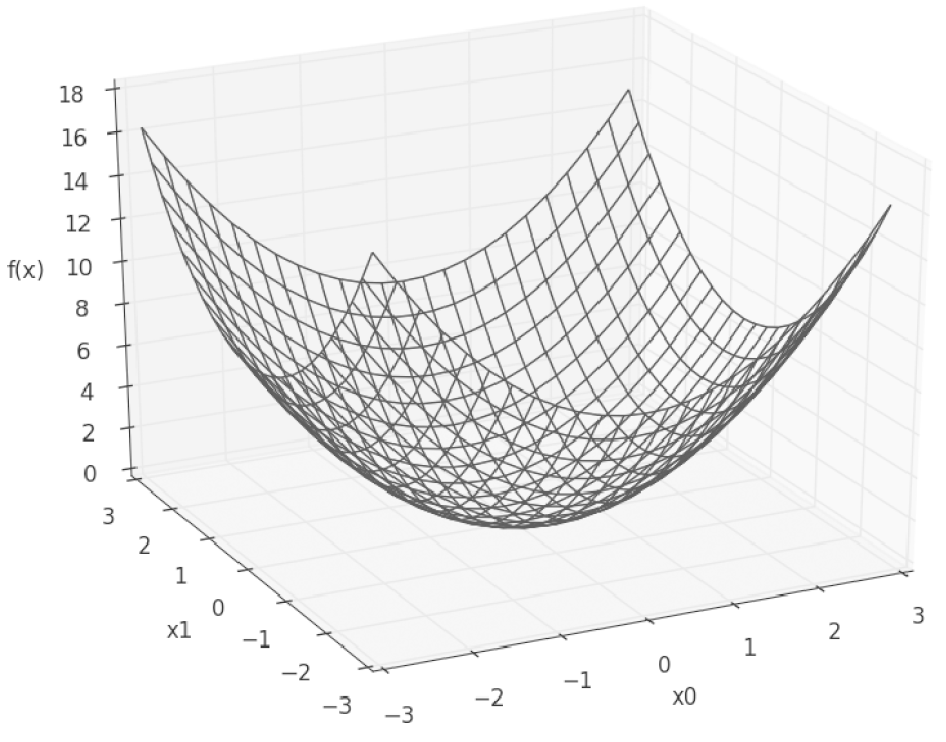

In [16]:
# 문제1: x0 = 3, x1 = 4일 때 x0에 대한 편미분을 구하라

def function_tmp1(x0):
  return x0*x0 + 4.0**2.0

numerical_diff(function_tmp1, 3.0)

6.00000000000378

In [17]:
# 문제2: x0 = 3, x1 = 4일 때, x1에 대한 편미분을 구하라

def function_tmp2(x1):
  return 3.0**2.0 + x1*x1

numerical_diff(function_tmp2, 4.0)

7.999999999999119

편미분은 변수가 하나인 미분과 마찬가지로 특정 장소의 기울기를 구함.

단, 여러 변수 중 목표 변수 하나에 초점을 맞추고 다른 변수는 값을 고정함.

## 기울기

모든 변수의 편비문을 벡터로 정리한 것을 기울기라고 함.

In [18]:
def numerical_gradient(f, x):
  h = 1e-4
  grad = np.zeros_like(x)

  for idx in range(x.size):
    tmp_val = x[idx]

    # f(x+h) 계산
    x[idx] = tmp_val + h
    fxh1 = f(x)

    # f(x-h) 계산
    x[idx] = tmp_val - h
    fxh2 = f(x)

    grad[idx] = (fxh1 - fxh2) / (2*h)
    x[idx] = tmp_val    # 값 복원

  return grad

In [19]:
# 기울기 구하기
print(numerical_gradient(function_2, np.array([3.0, 4.0])))
print(numerical_gradient(function_2, np.array([0.0, 2.0])))
print(numerical_gradient(function_2, np.array([3.0, 0.0])))

[6. 8.]
[0. 4.]
[6. 0.]


[기울기]

기울기는 함수의 '가장 낮은 장소(최솟값)'를 가리킴.

정확히는 기울기가 가리키는 쪽은 각 장소에서 함수의 출력 값을 가장 크게 줄이는 방향.

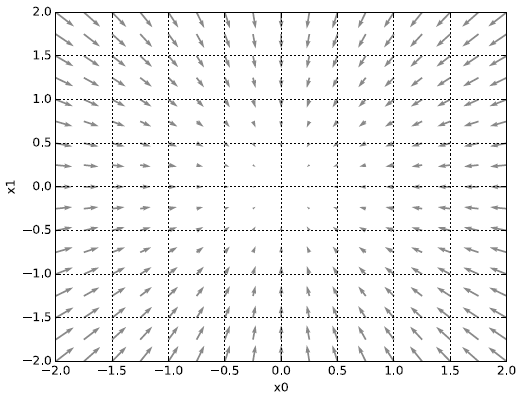

### 경사법(경사 하강법)

- 기울기를 이용해 함수의 최솟값(또는 가능한 한 작은 값)을 찾으려는 것
- 그러나 복잡한 함수에서는 기울기가 가리키는 방향에 최솟값이 없는 경우가 대부분임.
- 경사법은 현 위치에서 기울어진 방향으로 일정 거리만큼 이동하고 기울기를 구하고, 나아가는 것을 반복. 이렇게 해서 함수의 값을 점차 줄임.

[ 경사법 수식 ]

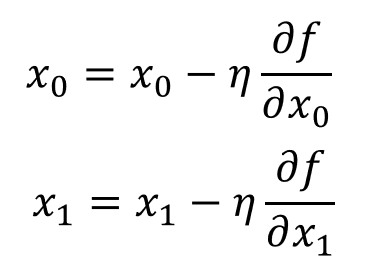

- η는 함수의 값을 갱신하는 양을 나타내며, 이를 신경망 학습에서는 학습률이라고 함.
- 계속 같은 식을 반복하여 함수의 값을 갱신하게 됨.
- 학습률 값은 너무 크거나 작으면 적절한 함수의 값을 찾을 수 없음.

In [20]:
# 경사하강법 구현
def gradient_descent(f, init_x, lr=0.01, step_num=100):
  x = init_x

  for i in range(step_num):
    grad = numerical_gradient(f, x)
    x -= lr *grad
  return x

In [21]:
# 경사법으로 최솟값 구하기
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

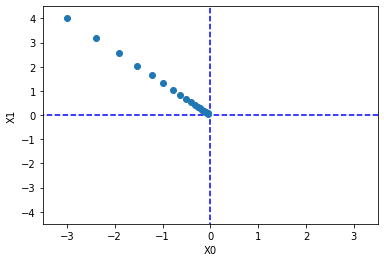

In [22]:
# 등고선으로 나타내기

import numpy as np
import matplotlib.pylab as plt
from gradient_2d import numerical_gradient


def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)


def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()